In [2]:
import numpy as np
import os
import cv2
from random import randint
import shutil

### Resize images

In [ ]:
'''
Resize to a specific size.
path_source - source folder path
path_destination - destination folder path
size= image size, default is 128x128
ext = file extension, default is *.png
'''
def imageResizer(path_source: str, path_destination:str, size=(128,128), ext='.png'):
    
    for folder in os.listdir(path_source):
        currentFolder = os.path.join(path_source, folder)
        if os.path.isdir(currentFolder):

            # Create new folder in processed images
            new_folder  =  os.path.join(path_destination,folder)
            os.makedirs(new_folder, exist_ok = True)
           
            for item in os.listdir(currentFolder):
                f_name, f_ext = os.path.splitext(item)
                if f_ext in ['.png','.bmp']:
    
                    # Processar a imagem
                    image_path = os.path.join(currentFolder,item)
                    image = cv2.imread(image_path)
                    image = image.copy()
                    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
                    resized_img = cv2.resize(image,size, interpolation = cv2.INTER_AREA)
        
                    # Salvar a imagem
                    target_path = os.path.join(new_folder, f_name+ext)
                    cv2.imwrite(target_path, resized_img)

In [ ]:
origin = '../datasets/LID_gf_imagesV3Extended(Original)'
destination = '../datasets/LID_gf_imagesV3Extended(resized)'
imageResizer(origin, destination)

### Divide dataset in train, validation and test 

In [ ]:
'''
Sample some items from dataset
path_source - source folder path
path_destination - destination folder path
sample_size = Number of items to be randomly selected in each folder, default is 145
'''
def datasetSpliter(path_source:str, path_destination:str, sample_size:str=145):
    # loop trough folders 
    for folder in os.listdir(path_source):
        currentFolder = os.path.join(path_source, folder)
        if os.path.isdir(currentFolder):

            # Create new folder in processed images
            destination_folder  =  os.path.join(path_destination,folder)
            os.makedirs(destination_folder, exist_ok = True)

            # Select items randomly and copy to destination
            count = 0
            while count < sample_size:

                # List all current folder items 
                current_folder_imgs = os.listdir(currentFolder)

                # Generate a random index
                index = randint(0,len(current_folder_imgs)-1)

                try:
                    # Select an image
                    selected_img = current_folder_imgs[index]

                    # Create source and destination path 
                    src_image_path = os.path.join(currentFolder, selected_img)
                    dst_image_path = os.path.join(destination_folder, selected_img)

                    # Move file from source to destination
                    shutil.move(src_image_path, dst_image_path) 
                    
                    # Increase counter
                    count += 1

                except IndexError:
                    pass  


In [ ]:
# Create validation data 
origin = '../datasets/LID_gf_imagesV3Extended(resized)'
destination = '../datasets/LID_gf_imagesV3Extended(processed)/validation_data'
datasetSpliter(origin, destination)

In [ ]:
# Create test data
origin = '../datasets/LID_gf_imagesV3Extended(resized)'
destination = '../datasets/LID_gf_imagesV3Extended(processed)/test_data'
datasetSpliter(origin, destination)

In [ ]:
# Create train data. Move the remaining files
origin = '../datasets/LID_gf_imagesV3Extended(resized)'
destination = '../datasets/LID_gf_imagesV3Extended(processed)/train_data'

for folder in os.listdir(origin):
    src_folder = os.path.join(origin, folder)
    dst_folder = os.path.join(destination, folder)

    # Move file from source to destination
    shutil.move(src_folder, dst_folder) 

In [ ]:
path_src = '../datasets/LID_gf_imagesV3Extended(Original)'
path_dest = '../datasets/LID_gf_imagesV3Extended(processed)'
dataset_folder = os.listdir(path_src)
dataset_folder

### Format to One-hot encoding


In [3]:
'''
Transform data into One-hot Encoding
path_source - source folder path
img_classes - dictionary with classes and corresponding numbers
size - size of the images. All images must be in the same size and extension. Default is (128,128,3)
'''
def oneHotEncoding(path_source:str, img_classes:dict, size:tuple=(128,128,3))->tuple[np.ndarray, np.ndarray]:

    # Get image size and number of classes
    image_size = size[0]*size[1]*size[2]
    nr_of_classes = len(img_classes)

    # Create empty arrays for X and Y 
    X_data = np.empty((0, image_size), dtype=np.uint8)
    Y_data = np.empty((0, nr_of_classes), dtype=np.uint8)
    
    for folder in os.listdir(path_source):
        currentFolder = os.path.join(path_source, folder)
        if (os.path.isdir(currentFolder)) and (not '.' in folder):
            
            for item in os.listdir(currentFolder):
                f_name, f_ext = os.path.splitext(item)
                if f_ext == '.png':
    
                    # Open image in RGB mode
                    image_path = os.path.join(currentFolder,item)
                    image = cv2.imread(image_path)
                    image = image.copy()
                    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
                  
                    # SET UP THE DATASET
                    # Vectorize the image and convert it into a list
                    img_arr = np.ndarray.flatten(image)

                    # Get the string of the image expression
                    if '_NA_'in f_name:
                        class_name, expression = f_name.split("_NA_")
                    elif '_WG_' in f_name:
                        class_name, expression = f_name.split("_WG_")
                    else:
                        class_name, expression = f_name.split("_")
                   
                    # Create a zero vector and set the value 1 for the corresponding class
                    label = np.zeros((1,nr_of_classes), dtype=np.uint8)
                    label[0][img_classes[class_name]]=1
                    
                    # Add items to the dataset
                    X_data = np.concatenate((X_data, img_arr.reshape(1,-1)), axis=0)
                    Y_data = np.concatenate((Y_data, label), axis=0)
   
    return X_data, Y_data

### Shuffle Data

In [4]:
def shuffleData(x_data:np.ndarray, y_data:np.ndarray) -> np.array:
    assert x_data.shape[0] == y_data.shape[0]
    data = np.concatenate((x_data, y_data), axis=1)

    # Shuffle data
    np.random.shuffle(data)

    # Split shuffled data 
    x_data = data[:, :x_data.shape[1]]
    y_data = data[:, -(y_data.shape[1]):]

    return x_data, y_data

In [5]:
# Process train_data

main_folder = '../datasets/LID_gf_imagesV3Extended(processed)/train_data'
img_classes = {'line':0, 'quad':1, 'cub':2, 'expo':3, 'log':4,
                    'root':5, 'sin':6, 'cos':7, 'tan':8, 'cot':9}
x,y = oneHotEncoding (main_folder, img_classes)

In [6]:
x_train_data, y_train_data = shuffleData(x,y)

In [7]:
# Process validation_data

main_folder = '../datasets/LID_gf_imagesV3Extended(processed)/validation_data'
img_classes = {'line':0, 'quad':1, 'cub':2, 'expo':3, 'log':4,
                    'root':5, 'sin':6, 'cos':7, 'tan':8, 'cot':9}
x,y = oneHotEncoding (main_folder, img_classes)

In [8]:
x_validation_data, y_validation_data = shuffleData(x,y)

In [9]:
# Process test_data

main_folder = '../datasets/LID_gf_imagesV3Extended(processed)/test_data'
img_classes = {'line':0, 'quad':1, 'cub':2, 'expo':3, 'log':4,
                    'root':5, 'sin':6, 'cos':7, 'tan':8, 'cot':9}
x,y = oneHotEncoding (main_folder, img_classes)

In [10]:
x_test_data, y_test_data = shuffleData(x,y)

### Save to pickle format 

In [17]:
import pickle


dataset = ((x_train_data, y_train_data), (x_validation_data, y_validation_data), (x_test_data, y_test_data))
with open ('../datasets/LID_fg_dataset.pkl', 'wb') as f:
  pickle.dump(dataset,f)

### Read files

In [12]:
import pickle

with open ('../datasets/LID_fg_dataset.pkl', 'rb') as arq:
    data = pickle.load(arq)

##### Os dados estão divididos em treino, validação e teste. Tem que extrair os dados:
```Python
(x_treino, y_treino), (x_validacao, y_validacao), (x_teste, y_teste) = data
```

* Para visualizar, tem que transformar para o tipo uint8
```Python
x_treino=x_treino.astype('uint8')
x_validacao = x_validacao.astype('uint8')
x_teste = x_teste.astype('uint8')
```

* Para treinar em uma rede neural tem que transformar para o tipo float e normalizar
```Python
x_treino=x_treino.astype('floa32')/255
x_validacao = x_validacao.astype('floa32')/255
x_teste = x_teste.astype('floa32')/255
```

In [15]:
(x_treino, y_treino), (x_validacao, y_validacao), (x_teste, y_teste) = data
x_treino=x_treino.astype('uint8')
x_validacao = x_validacao.astype('uint8')
x_teste = x_teste.astype('uint8')

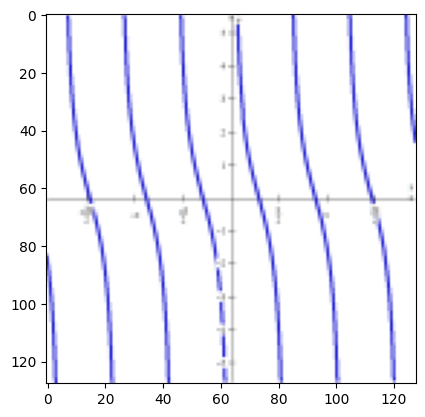

In [16]:
# Abrir uma imagem
import matplotlib.pyplot as plt
plt.imshow(x_treino[1].reshape(128,128,3))
plt.show()